In [9]:
import matplotlib.pyplot as plt
import numpy as np 
import tomopy


In [10]:
from projection_import import * 


FileObject = ProjectionFile("A:\\BAMline-CT\\2022\\2022_03\\Pch_21_09_10\\220317_1754_95_Pch_21_09_10_____Z40_Y8300_42000eV_10x_250ms\\220317_1754_95_00001.h5")
_,metadata = FileObject.openFile(volume = "/entry/data/data" , metadata = ['/entry/instrument/NDAttributes/CT_MICOS_W'])



volume opened successfully : data shape:  (2566, 1560, 2560)


In [88]:
img = FileObject.vol_proxy[200,:,:]
plt.imshow(img)


In [83]:
graph.shape

(2526,)

In [11]:
#variables : 

number_of_FFs = 20
COR = 1213
slice_number = 500
DarkFieldValue = 200
backIlluminationValue = 0
Offset_Angle = 0 # this is to rotate the reconstructed slice by
angle_rang = '180 - axis centered'# '360 - axis right' # could have 3 different types
extend_FOV_fixed_ImageJ_Stream = 0.25 # no idea what this is 
reco_algorithm = 'gridrec'
pixel_size = 0.72

In [12]:


#getting angles
line = metadata['/entry/instrument/NDAttributes/CT_MICOS_W']
graph= np.array(line[number_of_FFs:-number_of_FFs])


#find rotation start
i = 0
while i < graph.shape[0]:
    if round(graph[i]) == 0:  # notice the last projection at below 0.5°
        last_zero_proj = i + 3  # assumes 3 images for speeding up the motor
    i = i + 1

#estimate COR
if COR == 0:
    COR = (round(FileObject.vol_proxy.shape[2] / 2))
    

#FFs  Flat fields 


FFs = FileObject.vol_proxy[0:number_of_FFs -1, slice_number, :]
FFmean = np.mean(FFs, axis=0)

#sinogram 
Sino = FileObject.vol_proxy[number_of_FFs : -number_of_FFs, slice_number, :]

#normalize
Norm = np.divide(np.subtract(Sino, DarkFieldValue), np.subtract(FFmean, DarkFieldValue + backIlluminationValue))

#prefill rotation-speed[°/img]
#Polynom fit for the angles
poly_coeff = np.polyfit(np.arange(len(graph[round((graph.shape[0] + 1) /4) : round((graph.shape[0] + 1) * 3/4) ])), graph[round((graph.shape[0] + 1) /4) : round((graph.shape[0] + 1) * 3/4) ], 1, rcond=None, full=False, w=None, cov=False)
print('Polynom coefficients',poly_coeff, '   Detected angular step per image: ', poly_coeff[0])
speed_W = poly_coeff[0]


#reconstruction :
number_of_projections = Norm.shape[0]



#check if the scan was 180° or 360°
if number_of_projections * speed_W >= 270:
    number_of_used_projections = round(360 / speed_W)
else:
    #print('smaller than 3/2 Pi')
    number_of_used_projections = round(180 / speed_W)



# create list with all projection angles  based on radian 
new_list = (np.arange(number_of_used_projections) * speed_W + Offset_Angle) * np.pi / 180

# create list with x-positions of projections
full_size = Norm.shape[1]

if angle_rang == '360 - axis right':
    center_list = [COR + round((extend_FOV_fixed_ImageJ_Stream -1) * full_size)] * (number_of_used_projections)
    #center_list = [self.COR.value() +  self.full_size] * (self.number_of_used_projections)
else:
    center_list = [COR + round(extend_FOV_fixed_ImageJ_Stream * full_size)] * (number_of_used_projections)



# create one sinogram in the form [z, y, x]
transposed_sinos = np.zeros((min(number_of_used_projections, Norm.shape[0]), 1, full_size), dtype=float)
transposed_sinos[:,0,:] = Norm[last_zero_proj : min(last_zero_proj + number_of_used_projections, Norm.shape[0]),:]

#extend data with calculated parameter, compute logarithm, remove NaN-values
extended_sinos = tomopy.misc.morph.pad(transposed_sinos, axis=2, npad=round(extend_FOV_fixed_ImageJ_Stream * full_size), mode='edge')

# for 360° scans crop the padded area opposite of the axis

if angle_rang == '360 - axis right':
    
    extended_sinos = extended_sinos[:,:, full_size : ]

elif angle_rang == '360 - axis left':
    
    extended_sinos = extended_sinos[:,:, : - full_size]


#calculate -log
extended_sinos = tomopy.minus_log(extended_sinos)

#clean data
extended_sinos = np.nan_to_num(extended_sinos, copy=True, nan=1.0, posinf=1.0, neginf=1.0)


#reconstruct one slice
if reco_algorithm == 'FBP_CUDA':
    options = {'proj_type': 'cuda', 'method': 'FBP_CUDA'}
    slices = tomopy.recon(extended_sinos, new_list, center=center_list, algorithm=tomopy.astra, options=options)
else:
    slices = tomopy.recon(extended_sinos, new_list, center=center_list, algorithm=reco_algorithm,
                            filter_name=reco_algorithm)

# scale with pixel size to attenuation coefficients
slices = slices * (10000/pixel_size)


# trim reconstructed slice
if angle_rang == '180 - axis centered':
    slices = slices[:, round(extend_FOV_fixed_ImageJ_Stream * full_size / 2): -round(extend_FOV_fixed_ImageJ_Stream * full_size / 2),round(extend_FOV_fixed_ImageJ_Stream * full_size / 2): -round(extend_FOV_fixed_ImageJ_Stream * full_size / 2)]
else:
    slices = slices[:, round((extend_FOV_fixed_ImageJ_Stream -1) * full_size): -round((extend_FOV_fixed_ImageJ_Stream -1) * full_size),round((extend_FOV_fixed_ImageJ_Stream -1) * full_size): -round((extend_FOV_fixed_ImageJ_Stream -1) * full_size)]

slices = tomopy.circ_mask(slices, axis=0, ratio=1.0)
original_reconstruction = slices[0, :, :]


Polynom coefficients [ 0.07250538 45.71607613]    Detected angular step per image:  0.07250537565907467


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


In [23]:
FileObject.vol_proxy.shape[0]-2*20


2526

In [20]:
sino=FileObject.vol_proxy[20:-20,3,:]


In [21]:
sino.shape

(2526, 2560)

In [81]:
plt.imshow(slices[0,:,:])

In [59]:
transposed_sinos.shape

(2483, 1, 2560)

In [61]:
extended_sinos.shape

(2483, 1, 3840)

In [49]:
%matplotlib qt

plt.figure(1)
plt.imshow(Sino)

plt.figure(2)
plt.imshow(Norm)

In [22]:
graph.shape

(2526,)

In [10]:
np.array(line)

(<HDF5 dataset "data": shape (2566, 1560, 2560), type "<u2">,
 {'/entry/instrument/NDAttributes/CT_MICOS_W': <HDF5 dataset "CT_MICOS_W": shape (2566,), type "<f8">})

In [7]:

self.graph = numpy.array(self.line_proxy[self.spinBox_number_FFs.value(): -self.spinBox_number_FFs.value()])

(<HDF5 dataset "data": shape (2566, 1560, 2560), type "<u2">,
 {'/entry/instrument/NDAttributes/CT_MICOS_W': <HDF5 dataset "CT_MICOS_W": shape (2566,), type "<f8">})

In [1]:
# test my reconstruct code 

from reconstruct import * 

from projection_import import * 


FileObject = ProjectionFile("A:\\BAMline-CT\\2022\\2022_03\\Pch_21_09_10\\220317_1754_95_Pch_21_09_10_____Z40_Y8300_42000eV_10x_250ms\\220317_1754_95_00001.h5")
_,metadata = FileObject.openFile(volume = "/entry/data/data" , metadata = ['/entry/instrument/NDAttributes/CT_MICOS_W'])


reco_setting ={} 
reco_setting['angle_list_dir'] = '/entry/instrument/NDAttributes/CT_MICOS_W'
reco_setting["number_of_FFs"] = 20 
reco_setting["slice_number"]  = 500
reco_setting["DarkFieldValue"] = 200
reco_setting["backIlluminationValue"] = 0
reco_setting["COR"] = 1210
reco_setting["Offset_Angle"] = 0
reco_setting["angle_range"] = '180 - axis centered'
reco_setting["extend_FOV_fixed_ImageJ_Stream"] = 0.25
reco_setting["reco_algorithm"] = 'gridrec'
reco_setting["pixel_size"] = 0.72

reco = Reconstruction(FileObject,scan_type = 'on-the-fly')


INFO:root:Reconstruction object Imported
INFO:root:Reconstruction object Imported
INFO:root:projection file is HDF5 File object 


volume opened successfully : data shape:  (2566, 1560, 2560)


In [2]:
reco.on_the_fly_one_slice(reco_setting)

--- Logging error ---
Traceback (most recent call last):
  File "c:\ProgramData\Miniconda3\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "c:\ProgramData\Miniconda3\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "c:\ProgramData\Miniconda3\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "c:\ProgramData\Miniconda3\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\ProgramData\Miniconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\ProgramData\Miniconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\sdayani\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\sdayani\AppData\Roaming\Py

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

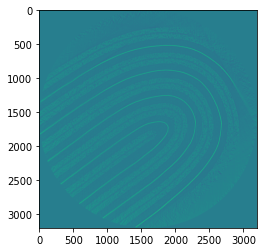

In [5]:
plt.imshow(reco.one_slice_reconstructed)

In [8]:
#change a setting and reco again 
# reco_setting ={} 
# reco_setting['angle_list_dir'] = '/entry/instrument/NDAttributes/CT_MICOS_W'
# reco_setting["number_of_FFs"] = 20 
# reco_setting["slice_number"]  = 500
# reco_setting["DarkFieldValue"] = 200
# reco_setting["backIlluminationValue"] = 0
reco_setting["COR"] = 1210
# reco_setting["Offset_Angle"] = 0
# reco_setting["angle_range"] = '180 - axis centered'
# reco_setting["extend_FOV_fixed_ImageJ_Stream"] = 0.25
# reco_setting["reco_algorithm"] = 'gridrec'
# reco_setting["pixel_size"] = 0.72

reco.on_the_fly_one_slice(reco_setting)

--- Logging error ---
Traceback (most recent call last):
  File "c:\ProgramData\Miniconda3\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "c:\ProgramData\Miniconda3\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "c:\ProgramData\Miniconda3\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "c:\ProgramData\Miniconda3\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\ProgramData\Miniconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\ProgramData\Miniconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\sdayani\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\sdayani\AppData\Roaming\Py

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [29]:
def check(v):
    return isinstance(v, tuple) and list(map(type, v)) == [int, int]

In [32]:
assert check((3.3,2)) , "we have a problem "

AssertionError: we have a problem 

In [38]:
len_all_slices = 500
def slice_in_range (v):
    if (v[0] <0 or v[0]>v[1] or v[0] > len_all_slices) : 
        return 'out range'
    if (v[1]<0 or v[1]<v[0] or v[1]> len_all_slices):
        return 'out of range' 
    else : 
        return True 

    

In [48]:
"Reconstruct a part of volume is selected {}".format ((5,6))

'Reconstruct a part of volume is selected (5, 6)'

In [54]:
len_all_slices = 500

slices_to_reco = "all"
def tuple_int(v):
    return isinstance(v, tuple) and list(map(type, v)) == [int, int]

def reco_all ():
    return (0,len_all_slices) # reconstruct all

def slice_in_range (v):
    if (v[0] <0 or v[0]>v[1] or v[0] > len_all_slices) : 
        return False
    if (v[1]<0 or v[1]<v[0] or v[1]> len_all_slices):
        return False 
    else : 
        return True 

if slices_to_reco != 'all' : # a range of slices is selected 
    if tuple_int(slices_to_reco) and slice_in_range(slices_to_reco): # check if it is tuple with two int values are in range
        logging.info("Reconstruct a part of volume is selected {}".format (slices_to_reco))
    else :
        slices_to_reco = reco_all() # if not, auto select all vol to reconstruct
        logging.info("Reconstruct whole volume is autoselected ")
elif slices_to_reco == 'all':
    slices_to_reco = reco_all()
    logging.info("Reconstruct whole volume is selected ")

                

INFO:root:Reconstruct whole volume is selected 
